# Hidden Mickey classification using pre-trained VGG16 network features

In [1]:
import historyPlot

import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input
from keras import applications
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def plotImage(image, result):
    plt.imshow(image)
    plt.title(result)    
    plt.show()   

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same
# machine, in which case use CPU and leave the
# GPU for training.

DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0\n",

In [4]:
# input image dimension
input_image_dim  = 224

batch_size = 16
epochs = 100

## Prepare data

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)

validation_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('dataset/training_set',
                                                 target_size = (input_image_dim, input_image_dim),
                                                 batch_size = batch_size,
                                                 class_mode = 'binary',
                                                 shuffle=False)


validation_set = validation_datagen.flow_from_directory('dataset/test_set',
                                            target_size = (input_image_dim, input_image_dim),
                                            batch_size = batch_size,
                                            class_mode = 'binary',
                                            shuffle=False)

training_set.class_indices

Found 348 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


{'mickey': 0, 'non-mickey': 1}

## Extract VGG16 features for the given training and validation data sets

In [6]:
with tf.device(DEVICE):
    input_tensor = Input(shape=(input_image_dim,input_image_dim,3))
    conv_base = applications.VGG16(include_top=False, 
                                   weights='imagenet',
                                   input_shape=(input_image_dim, input_image_dim, 3),
                                   input_tensor=input_tensor)

    print('Extracting convolution base training data set features')
    conv_base_features_train = conv_base.predict_generator(training_set)
    
    print('Extracting convolution base validation data set features')
    conv_base_features_validation = conv_base.predict_generator(validation_set)

    print(conv_base.summary()) 



Extracting convolution base training data set features
Extracting convolution base validation data set features
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________

## Prepare labels

In [7]:
# prepare training labels
train_labels = []

for i in range(0,int(len(training_set))):
    train_labels.extend(np.array(training_set[i][1]))    

train_labels = np.array(train_labels).astype(int)


#print('training labels = ', train_labels)

# prepare validation labels
validation_labels = []

for i in range(0,int(len(validation_set))):
    validation_labels.extend(np.array(validation_set[i][1]))    

validation_labels = np.array(validation_labels).astype(int)        

#print('validation labels = ', train_labels)


## Fit classification model using the extracted VGG16 features

In [8]:
with tf.device(DEVICE):
    
    hmModel = Sequential()
    hmModel.add(Flatten(input_shape=conv_base_features_train.shape[1:]))
    hmModel.add(Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    hmModel.add(Dropout(0.5))
    hmModel.add(Dense(1, kernel_regularizer=regularizers.l2(0.001), activation='sigmoid'))

    print(hmModel.summary()) 

    hmModel.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(lr=0.0001),
                    metrics=['accuracy'])
    
    # checkpoint
    callbacksList = None
    filepath="hm.weights.best.vgg16-3a.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, 
                                 save_weights_only=True, mode='max')
    callbacksList = [checkpoint]

    history = hmModel.fit(conv_base_features_train, train_labels,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(conv_base_features_validation, validation_labels),
                          callbacks=callbacksList)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________
None
Train on 348 samples, validate on 182 samples
Epoch 1/100
348/348 [==============================] - 3s 9ms/step - loss: 0.9174 - acc: 0.8420 - val_loss: 0.5807 - val_acc: 0.9066

Epoch 00001: val_acc improved from -inf to 0.90659, saving model to hm.weights.

348/348 [==============================] - 1s 2ms/step - loss: 0.0145 - acc: 1.0000 - val_loss: 0.1532 - val_acc: 0.9505

Epoch 00039: val_acc did not improve from 0.95055
Epoch 40/100
348/348 [==============================] - 1s 2ms/step - loss: 0.0147 - acc: 1.0000 - val_loss: 0.1957 - val_acc: 0.9396

Epoch 00040: val_acc did not improve from 0.95055
Epoch 41/100
348/348 [==============================] - 1s 2ms/step - loss: 0.0129 - acc: 1.0000 - val_loss: 0.1623 - val_acc: 0.9451

Epoch 00041: val_acc did not improve from 0.95055
Epoch 42/100
348/348 [==============================] - 1s 2ms/step - loss: 0.0249 - acc: 0.9971 - val_loss: 0.1799 - val_acc: 0.9451

Epoch 00042: val_acc did not improve from 0.95055
Epoch 43/100
348/348 [==============================] - 1s 2ms/step - loss: 0.0141 - acc: 0.9971 - val_loss: 0.2425 - val_acc: 0.9286

Epoch 00043: val_acc did not improve from 0.95055
Epoch 44/100
348/348 [==============================] - 1s 2ms/step - loss: 0.0123 - acc

348/348 [==============================] - 1s 2ms/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.1430 - val_acc: 0.9560

Epoch 00083: val_acc did not improve from 0.95604
Epoch 84/100
348/348 [==============================] - 1s 2ms/step - loss: 0.0094 - acc: 1.0000 - val_loss: 0.2212 - val_acc: 0.9396

Epoch 00084: val_acc did not improve from 0.95604
Epoch 85/100
348/348 [==============================] - 1s 2ms/step - loss: 0.0069 - acc: 1.0000 - val_loss: 0.1962 - val_acc: 0.9451

Epoch 00085: val_acc did not improve from 0.95604
Epoch 86/100
348/348 [==============================] - 1s 2ms/step - loss: 0.0085 - acc: 1.0000 - val_loss: 0.1710 - val_acc: 0.9560

Epoch 00086: val_acc did not improve from 0.95604
Epoch 87/100
348/348 [==============================] - 1s 2ms/step - loss: 0.0074 - acc: 1.0000 - val_loss: 0.1479 - val_acc: 0.9560

Epoch 00087: val_acc did not improve from 0.95604
Epoch 88/100
348/348 [==============================] - 1s 2ms/step - loss: 0.0081 - acc

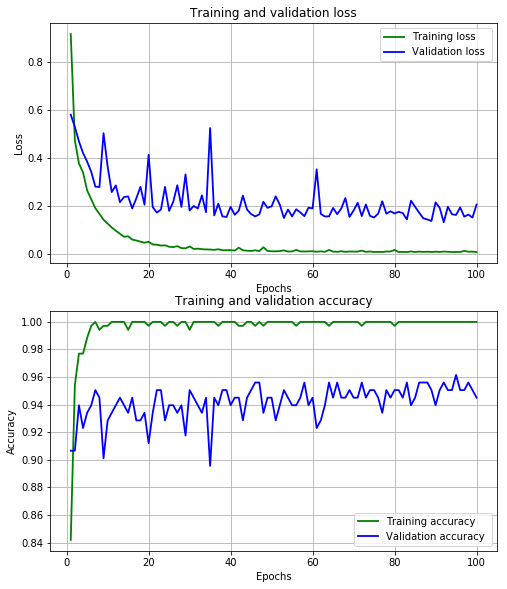

In [9]:
historyPlot.plotHistoryArray([history])

In [10]:
# Build model for predictions
with tf.device(DEVICE):

    # Build model for predictions with a fully-trained
    # VGG16 CNN base and the pre-trained top classifier
    input_tensor = Input(shape=(input_image_dim,input_image_dim,3))
    vgg16ConvBase = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=conv_base_features_train.shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    # Load classifier model weights
    top_model.load_weights('hm.weights.best.vgg16-3a.hdf5')

    # Create prediction model from VGG16
    # by copying all the layers
    prediction_model = Sequential()
    for l in vgg16ConvBase.layers:
        prediction_model.add(l)

    # concatenate the two models
    prediction_model.add(top_model)

    prediction_model.compile(optimizer=optimizers.RMSprop(lr=0.0005),
                  loss='binary_crossentropy', metrics=['accuracy'])    

    print(prediction_model.summary())    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [11]:
results = prediction_model.evaluate_generator(validation_set)
print("Model test results: ", results)

Model test results:  [0.15626643000011955, 0.9615384615384616]


dataset/prediction/01-royal-rooms-hidden-mickey-11.jpg [[0.]] mickey


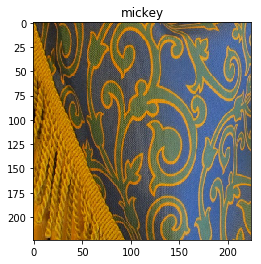

dataset/prediction/10734_big.jpg [[0.]] mickey


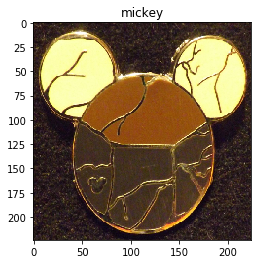

dataset/prediction/20180210_130801-M.jpg [[1.]] non-mickey


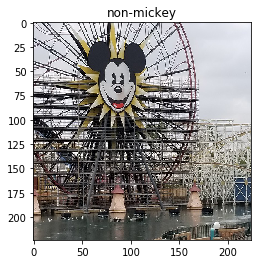

dataset/prediction/3389555126_4d7b74ff0a_b.jpg [[0.]] mickey


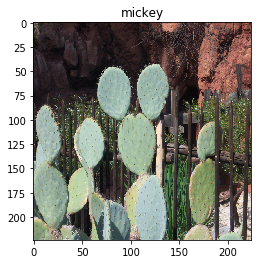

dataset/prediction/5306bc8f63e1762c5ccce18722462da6--mickey-disney-mickey-mouse.jpg [[0.]] mickey


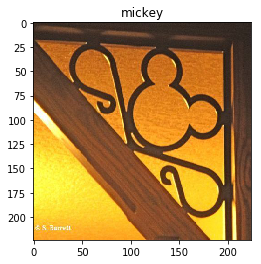

dataset/prediction/avenger.jpg [[1.]] non-mickey


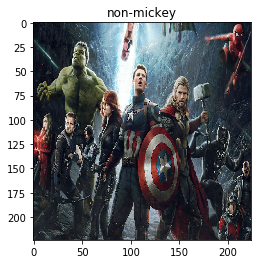

dataset/prediction/california_disneyland_article.jpg [[0.]] mickey


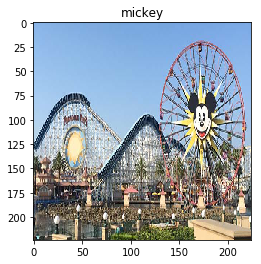

dataset/prediction/cattles.jpg [[1.]] non-mickey


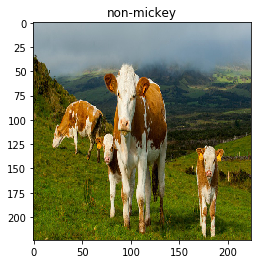

dataset/prediction/cow.jpg [[1.]] non-mickey


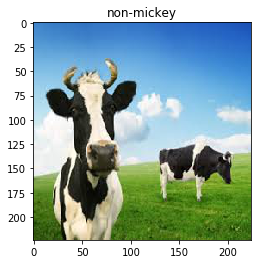

dataset/prediction/DFgg3zh_Xo_AIr_Xp4.jpg [[0.]] mickey


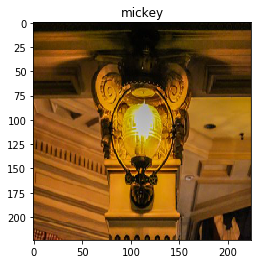

dataset/prediction/dl2_orig.jpg [[0.]] mickey


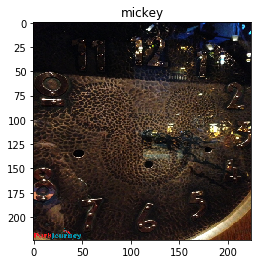

dataset/prediction/edc74fdf1b37fbdd92281215a777622a.jpg [[1.]] non-mickey


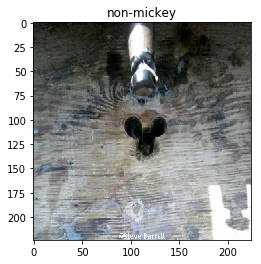

dataset/prediction/EPCOTSecrets_hiddenmickey_glover.jpg [[1.]] non-mickey


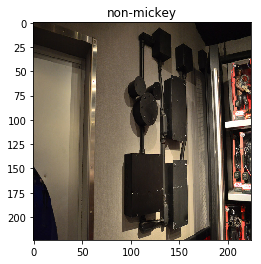

dataset/prediction/fish.jpg [[1.]] non-mickey


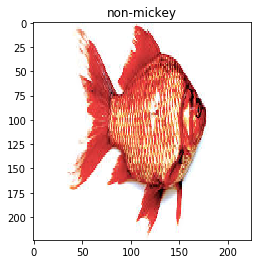

dataset/prediction/fish2.jpg [[1.]] non-mickey


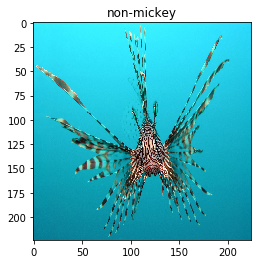

dataset/prediction/fish3.jpg [[1.]] non-mickey


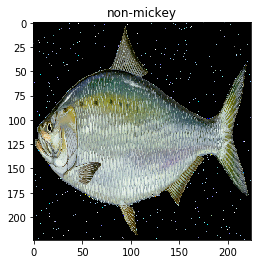

dataset/prediction/Haunted-Mansion.jpg [[0.]] mickey


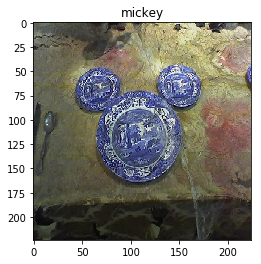

dataset/prediction/hidden-mickey-720x340.jpg [[1.]] non-mickey


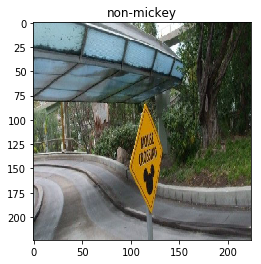

dataset/prediction/Hidden-Mickey-Canada-Pavilion-Epcot.jpg [[0.]] mickey


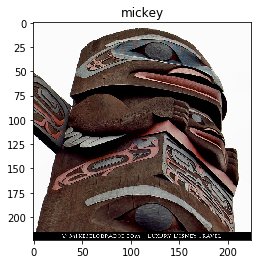

dataset/prediction/HiddenMickeyEPCOTCanada.jpg [[0.]] mickey


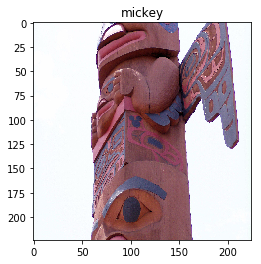

dataset/prediction/HiddenMickeys.jpg [[0.]] mickey


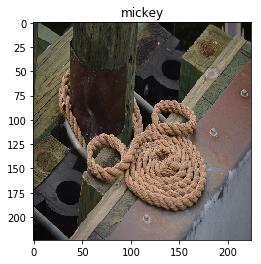

dataset/prediction/hm-1-images.jpg [[0.]] mickey


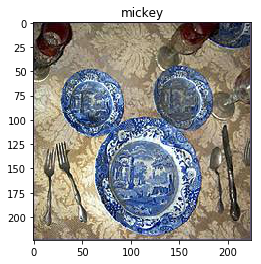

dataset/prediction/hm-2-images.jpg [[0.]] mickey


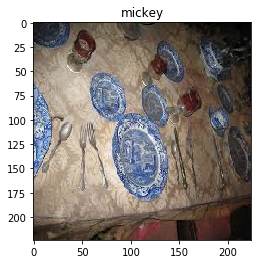

dataset/prediction/hm-3-images.jpg [[0.]] mickey


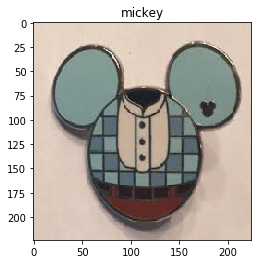

dataset/prediction/ht_totem_pole_101027_ssh.jpg [[0.]] mickey


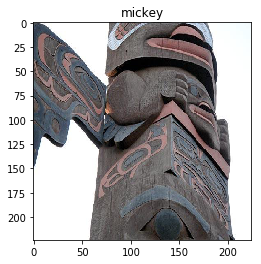

dataset/prediction/img_1271.jpg [[0.]] mickey


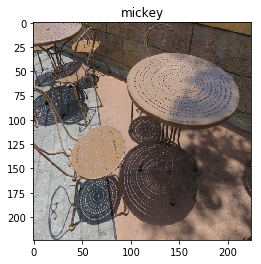

dataset/prediction/incredibles.jpg [[0.]] mickey


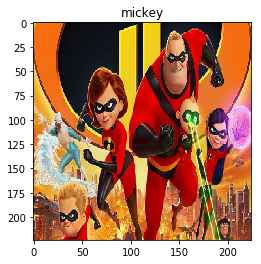

dataset/prediction/ladiesandtramp.jpg [[0.]] mickey


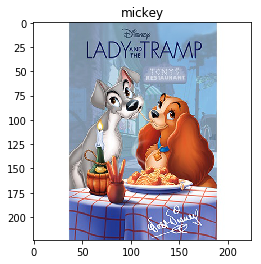

dataset/prediction/mickey1.jpg [[1.]] non-mickey


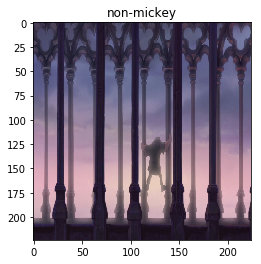

dataset/prediction/mickey2.jpg [[0.]] mickey


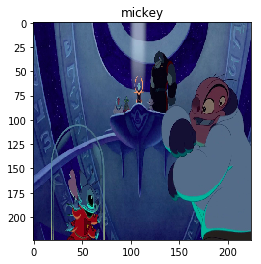

dataset/prediction/mickey3.jpg [[0.]] mickey


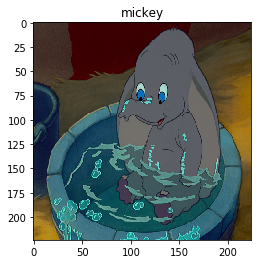

dataset/prediction/mickey4.jpg [[0.]] mickey


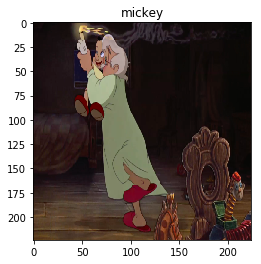

dataset/prediction/mickey5.jpg [[0.]] mickey


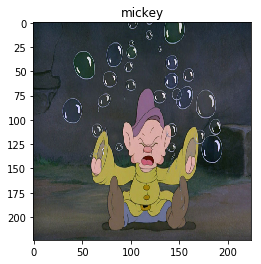

dataset/prediction/mickey6.jpg [[0.]] mickey


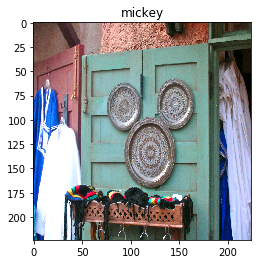

dataset/prediction/mickey7.jpg [[0.]] mickey


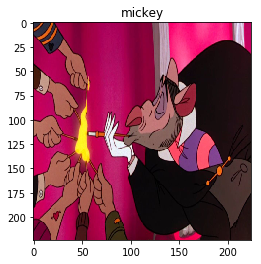

dataset/prediction/mickey8.jpg [[0.]] mickey


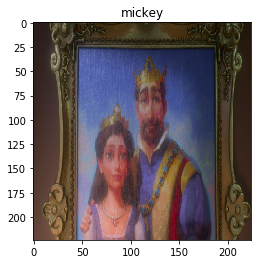

dataset/prediction/mickey9.jpg [[0.]] mickey


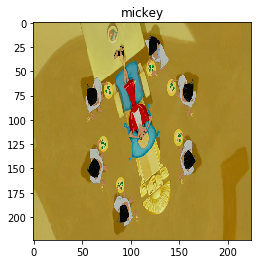

dataset/prediction/mickeyinfield.jpg [[0.]] mickey


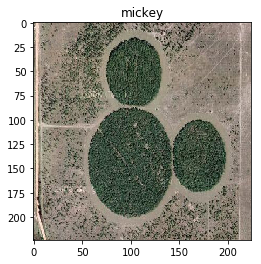

dataset/prediction/pixar-pier-rides-guide-disney-california-adventure.jpg [[1.]] non-mickey


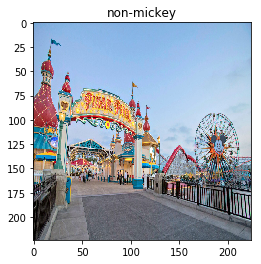

dataset/prediction/Rope-Hidden-Mickey.jpg [[1.]] non-mickey


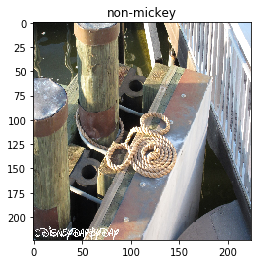

In [12]:
import numpy as np
import os
from keras.preprocessing import image


prediction_path = 'dataset/prediction/'

folder = os.fsencode(prediction_path)

for file in os.listdir(folder):
  filename = os.fsdecode(file)
  if filename.endswith( ('.jpg', '.png', '.gif') ): # whatever file types you're using...    
    prediction_image_filename = prediction_path + filename 
    prediction_image = image.load_img(prediction_image_filename, target_size = (input_image_dim, input_image_dim))
    prediction_image = image.img_to_array(prediction_image)
    #prediction_image = prediction_image / 255
    prediction_image = np.expand_dims(prediction_image, axis = 0)
    result = np.round(prediction_model.predict(prediction_image))
    # 0 = mickey , 1 = non-mickey
    #print (result)
    if result[0][0] == 0:
      prediction_result = 'mickey'
    else:
      prediction_result = 'non-mickey'
 
    print (prediction_image_filename , result, prediction_result)
    plotImage(prediction_image[0]/255, prediction_result)




## Fine tuning the model

In [ ]:
with tf.device(DEVICE):
    
    # Lock the layers
    conv_base.trainable = False

    set_trainable = False
    for layer in prediction_model.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False        
    
    print(prediction_model.summary())    
    
    # checkpoint
    callbacksList = None
    filepath="hm.weights.best.vgg16-4a.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, 
                                 save_weights_only=True, mode='max')
    callbacksList = [checkpoint]
    
    history = prediction_model.fit_generator(training_set, steps_per_epoch = 100, 
                        epochs = epochs, 
                        validation_data = validation_set, 
                        validation_steps = 50,
                        callbacks=callbacksList)